In [9]:
# --------------------------------------------------------------------------------------------------------------------------------------------
# imports
# --------------------------------------------------------------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------------------------------------------------
# functions
# --------------------------------------------------------------------------------------------------------------------------------------------

def enumerate_states(N, M):
    """
    Function to enumerate all possible states of a system with N lattice sites and M synthetic levels.
    
    Inputs:
    N (int): Number of lattice sites.
    M (int): Number of synthetic levels.
    
    Returns:
    states (list): List of all possible states, each state represented as a list of integers.
    formatted_states (list): List of formatted state strings for easy visualization.
    """
    
    if N <= 0 or M <= 0:
        return [], []

    states = []
    current_state = [0] * N

    while True:
        states.append(current_state.copy())

        for i in range(N-1, -1, -1):
            if current_state[i] < M-1:
                current_state[i] += 1
                break
            else:
                current_state[i] = 0
        else:
            break

    if M**N == len(states):
        formatted_states = ["|" + ",".join(map(str, state)) + ">" for state in states]
        return states, formatted_states
    
    else:
        print("There was an issue enumerating the states.") 
        return [], []
    
# --------------------------------------------------------------------------------------------------------------------------------------------

def initialize_hamiltonian(N, M):
    """
    Initialize a zero matrix for the Hamiltonian of size M^N x M^N.
    
    Inputs:
    N (int): Number of lattice sites.
    M (int): Number of synthetic levels.
    
    Returns:
    H (np.ndarray): Initialized Hamiltonian matrix of size M^N x M^N.
    """
    
    num_states = M**N
    H = np.zeros((num_states, num_states), dtype=np.complex128)
    return H

# --------------------------------------------------------------------------------------------------------------------------------------------

def get_new_state(state, site, new_level):
    """
    Generate a new state by changing the level of a particle at a given lattice site.
    
    Inputs:
    state (list): Current state configuration represented as a list of integers.
    site (int): Index of the lattice site to change.
    new_level (int): New synthetic level for the lattice site.
    
    Returns:
    new_state (list): New state configuration after modifying the specified lattice site.
    """
    
    new_state = state.copy()
    new_state[site] = new_level
    return new_state

# --------------------------------------------------------------------------------------------------------------------------------------------

def get_double_new_state(state, site1, level1, site2, level2):
    """
    Generate a new state by changing the levels of particles at two lattice sites.
    
    Inputs:
    state (list): Current state configuration represented as a list of integers.
    site1 (int): Index of the first lattice site to change.
    level1 (int): New synthetic level for the first lattice site.
    site2 (int): Index of the second lattice site to change.
    level2 (int): New synthetic level for the second lattice site.
    
    Returns:
    new_state (list): New state configuration after modifying the specified lattice sites.
    """
    
    new_state = state.copy()
    new_state[site1] = level1
    new_state[site2] = level2
    return new_state

# --------------------------------------------------------------------------------------------------------------------------------------------

def state_index(state, all_states):
    """
    Get the index of a given state in the list of all states.
    
    Inputs:
    state (list): State whose index is to be found.
    all_states (list): List of all states.
    
    Returns:
    index (int): Index of the state in the list of all_states.
    """
    
    return all_states.index(state)

# --------------------------------------------------------------------------------------------------------------------------------------------

def construct_hamiltonian(N, M, J, V):
    """
    Construct the Hamiltonian matrix including tunneling and interaction terms.
    
    Inputs:
    N (int): Number of lattice sites.
    M (int): Number of synthetic levels.
    t (float): Tunneling parameter.
    V (float): Interaction strength.
    
    Returns:
    H (np.ndarray): Constructed Hamiltonian matrix of size M^N x M^N.
    formatted_states (list): List of formatted state strings for easy visualization.
    """
    
    states, formatted_states = enumerate_states(N, M)
    H = initialize_hamiltonian(N, M)
    
    for state in states:
        current_index = state_index(state, states)
        
        for i in range(N):  # Loop over lattice sites
            for n in range(1, M):  # Loop over synthetic levels
                # -t * (c_{n-1,j}^\dagger c_{n,j} + h.c.) term (tunneling term)
                if state[i] == n:
                    new_state = get_new_state(state, i, n-1)
                    new_index = state_index(new_state, states)
                    H[current_index, new_index] -= J  # Adding the tunneling element with -t
                    H[new_index, current_index] -= J  # Hermitian conjugate term
                
                # V * c_{n-1,j}^\dagger c_{n,j} c_{n,i}^\dagger c_{n-1,i} term (interaction term)
                for j in range(N):
                    if i != j and state[i] == n and state[j] == n-1:
                        new_state = get_double_new_state(state, i, n-1, j, n)
                        new_index = state_index(new_state, states)
                        H[current_index, new_index] += V  # Adding the interaction term
                        H[new_index, current_index] += V  # Hermitian conjugate term

    return H, formatted_states

# --------------------------------------------------------------------------------------------------------------------------------------------

def exact_diagonalize(H, verbose=False, check_reconstruction=False):
    """
    Diagonalize a matrix using numpy.linalg.eigh().
    
    Inputs:
    H (np.ndarray): Hermitian matrix to be diagonalized.
    verbose (bool): Controls whether the eigenvalues and eigenvectors are printed.
    check_reconstruction (bool): Controls whether the reconstructed matrix is checked against the original.
    
    Outputs:
    V (np.ndarray): Matrix whose columns are the eigenvectors of H.
    D (np.ndarray): Diagonal matrix containing the eigenvalues of H.
    """
    
    if not np.allclose(np.conjugate(H.T), H):
        print("The matrix is not Hermitian. Please check the input matrix.")
        return None, None
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    D = np.diag(eigenvalues)
    V = eigenvectors 
    
    if verbose:
        print("Eigenvalues (D) = \n", D, "\n")
        print("Eigenvectors (V) = \n", V, "\n")
        
    if check_reconstruction:
        reconstructed_H = V @ D @ np.conjugate(V.T)
        if np.allclose(reconstructed_H, H):
            print("Faithfully reconstructed the matrix.")
        else: 
            print("Reconstruction failed.")
    
    return V, D    
    
# --------------------------------------------------------------------------------------------------------------------------------------------

def create_H_key(formatted_states):
    """
    Create a matrix H_key where each element is a formatted string combination of state indices.

    Inputs:
    formatted_states (list): List of formatted state strings.

    Returns:
    H_key (np.ndarray): Matrix where each element is a formatted string combination of state indices.
    """
    
    M_pow_N = len(formatted_states)
    H_key = np.empty((M_pow_N, M_pow_N), dtype=object)

    for x in range(M_pow_N):
        for y in range(M_pow_N):
            H_key[x, y] = "<" + formatted_states[x][::-1][1:] + "H" + formatted_states[y]

    return H_key

# --------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# verifying matrix elements 
"""M = 2
N = 2

J = 1.0  # Tunneling parameter
V = 2.0  # Interaction strength

H, formatted_states = construct_hamiltonian(N, M, J, V)
H_key = create_H_key(formatted_states)
print("Hamiltonian Matrix:")
print(H)
print(H_key)

V_matrix, D_matrix = exact_diagonalize(H)

eigenvalues = np.diag(D_matrix)
eigenvectors = [V_matrix[:, col_idx] for col_idx in range(V_matrix.shape[1])]

for i in range(len(eigenvalues)):
    print(f"Eigenvalue {i}: {np.round(eigenvalues[i],3)}")
    print(f"Eigenvector {i}: {np.round(eigenvectors[i],3)}\n")
"""

Hamiltonian Matrix:
[[ 0.+0.j -1.+0.j -1.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  4.+0.j -1.+0.j]
 [-1.+0.j  4.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j -1.+0.j -1.+0.j  0.+0.j]]
[['<0,0|H|0,0>' '<0,0|H|0,1>' '<0,0|H|1,0>' '<0,0|H|1,1>']
 ['<1,0|H|0,0>' '<1,0|H|0,1>' '<1,0|H|1,0>' '<1,0|H|1,1>']
 ['<0,1|H|0,0>' '<0,1|H|0,1>' '<0,1|H|1,0>' '<0,1|H|1,1>']
 ['<1,1|H|0,0>' '<1,1|H|0,1>' '<1,1|H|1,0>' '<1,1|H|1,1>']]


1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


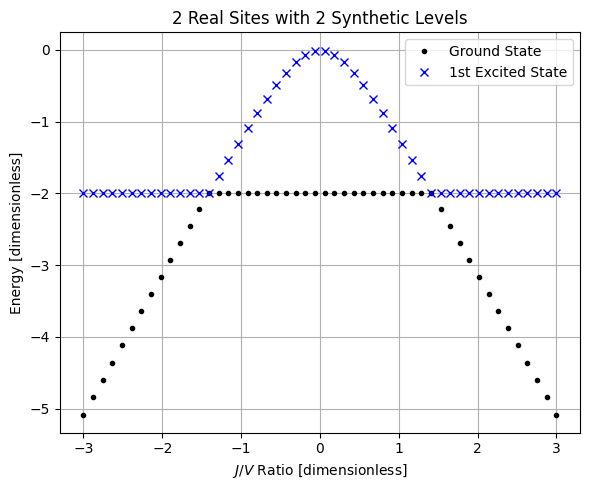

In [17]:
# computing energy spectra for a single case
 
J_V_ratios = np.linspace(-3,3,50)

N = 2
M = 2

V = 1.0

gs_energies = []
first_es_energies = []
second_es_energies = []

for i, J_V_ratio in enumerate(J_V_ratios):
    J = J_V_ratio * V

    H, formatted_states = construct_hamiltonian(N, M, J, V)
    V_matrix,D_matrix = exact_diagonalize(H)
    eigenvalues = np.diag(D_matrix)
    eigenvectors = [V_matrix[:, col_idx] for col_idx in range(V_matrix.shape[1])]
    
    gs_energies.append(eigenvalues[0])
    first_es_energies.append(eigenvalues[1])
    second_es_energies.append(eigenvalues[2])
    print(f"{i+1}/{len(J_V_ratios)}")
    
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(J_V_ratios, gs_energies, ".k", label = "Ground State")
ax.plot(J_V_ratios, first_es_energies, "xb", label = "1st Excited State")
#ax.plot(J_V_ratios, second_es_energies, "+r", label = "2nd Excited State")
ax.set_title(f"{N} Real Sites with {M} Synthetic Levels")
ax.set_xlabel("$J/V$ Ratio [dimensionless]")
ax.set_ylabel("Energy [dimensionless]")
ax.grid()
ax.legend()
plt.tight_layout()

N=2,M=2
1/50
N=2,M=2
2/50
N=2,M=2
3/50
N=2,M=2
4/50
N=2,M=2
5/50
N=2,M=2
6/50
N=2,M=2
7/50
N=2,M=2
8/50
N=2,M=2
9/50
N=2,M=2
10/50
N=2,M=2
11/50
N=2,M=2
12/50
N=2,M=2
13/50
N=2,M=2
14/50
N=2,M=2
15/50
N=2,M=2
16/50
N=2,M=2
17/50
N=2,M=2
18/50
N=2,M=2
19/50
N=2,M=2
20/50
N=2,M=2
21/50
N=2,M=2
22/50
N=2,M=2
23/50
N=2,M=2
24/50
N=2,M=2
25/50
N=2,M=2
26/50
N=2,M=2
27/50
N=2,M=2
28/50
N=2,M=2
29/50
N=2,M=2
30/50
N=2,M=2
31/50
N=2,M=2
32/50
N=2,M=2
33/50
N=2,M=2
34/50
N=2,M=2
35/50
N=2,M=2
36/50
N=2,M=2
37/50
N=2,M=2
38/50
N=2,M=2
39/50
N=2,M=2
40/50
N=2,M=2
41/50
N=2,M=2
42/50
N=2,M=2
43/50
N=2,M=2
44/50
N=2,M=2
45/50
N=2,M=2
46/50
N=2,M=2
47/50
N=2,M=2
48/50
N=2,M=2
49/50
N=2,M=2
50/50
N=2,M=3
1/50
N=2,M=3
2/50
N=2,M=3
3/50
N=2,M=3
4/50
N=2,M=3
5/50
N=2,M=3
6/50
N=2,M=3
7/50
N=2,M=3
8/50
N=2,M=3
9/50
N=2,M=3
10/50
N=2,M=3
11/50
N=2,M=3
12/50
N=2,M=3
13/50
N=2,M=3
14/50
N=2,M=3
15/50
N=2,M=3
16/50
N=2,M=3
17/50
N=2,M=3
18/50
N=2,M=3
19/50
N=2,M=3
20/50
N=2,M=3
21/50
N=2,M=3
22/50
N=2,M=3
23

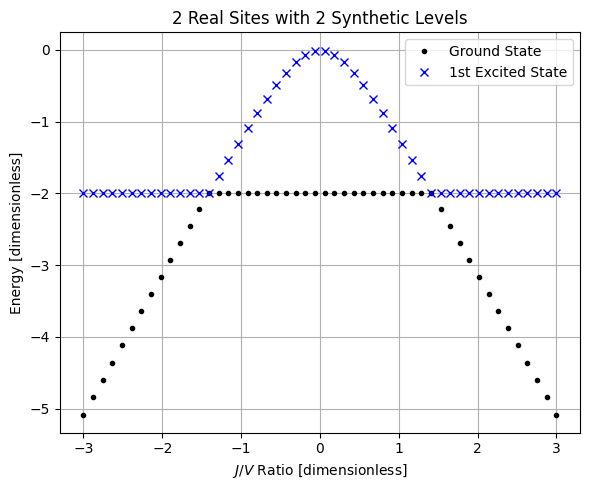

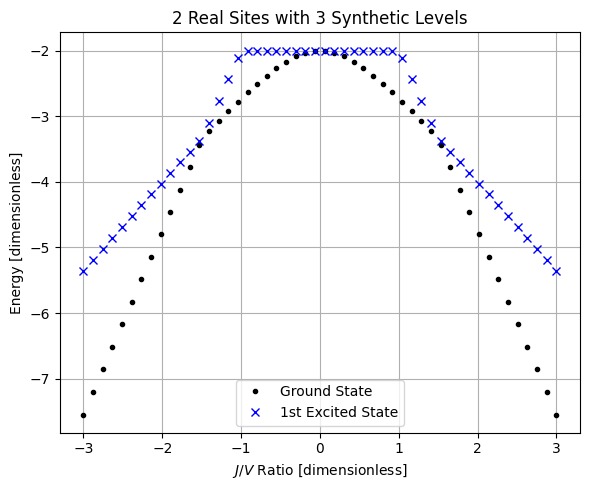

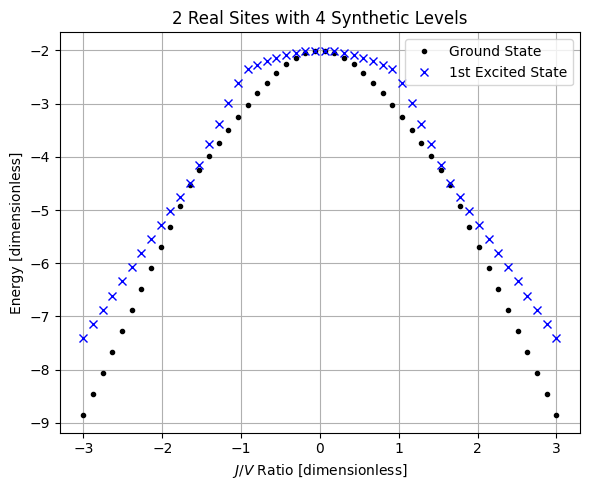

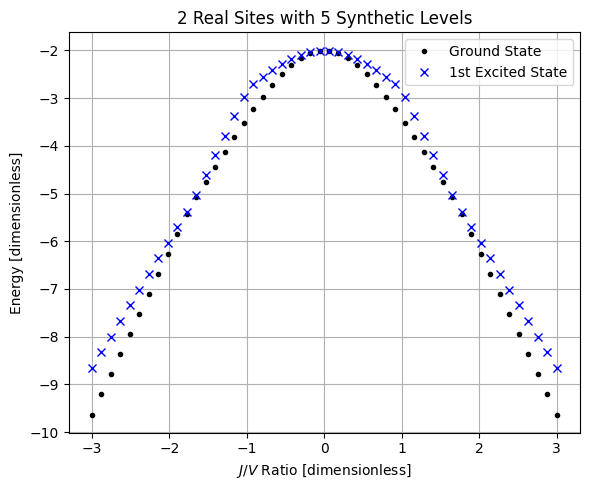

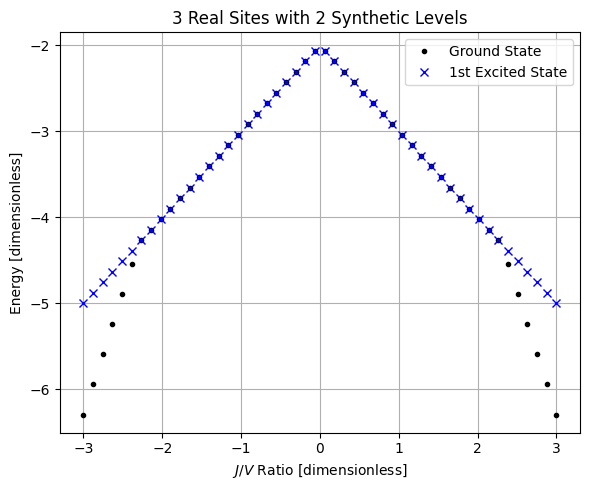

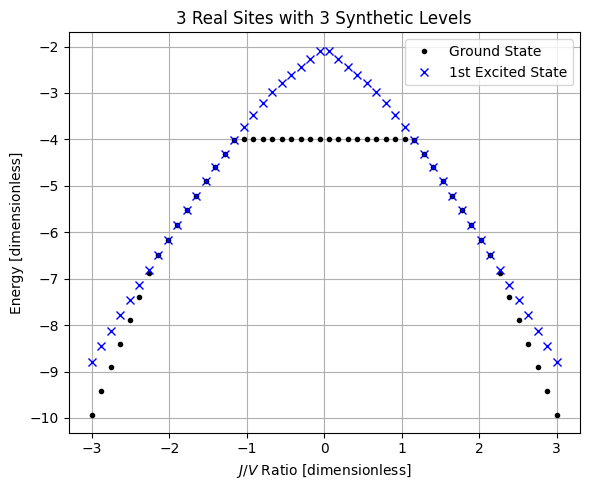

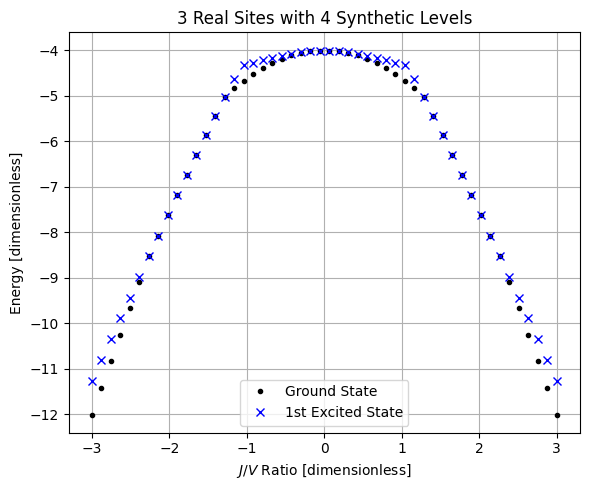

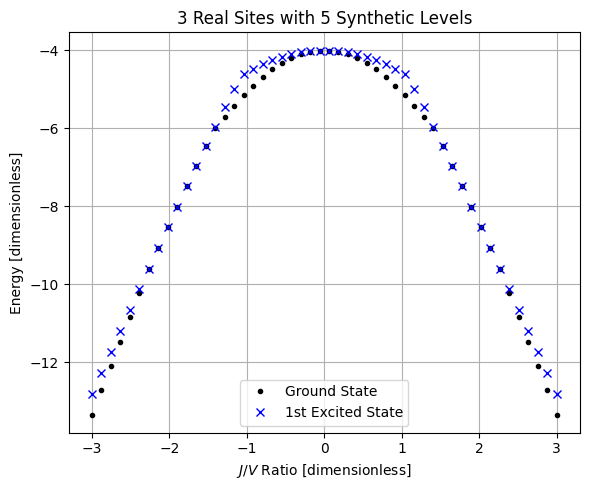

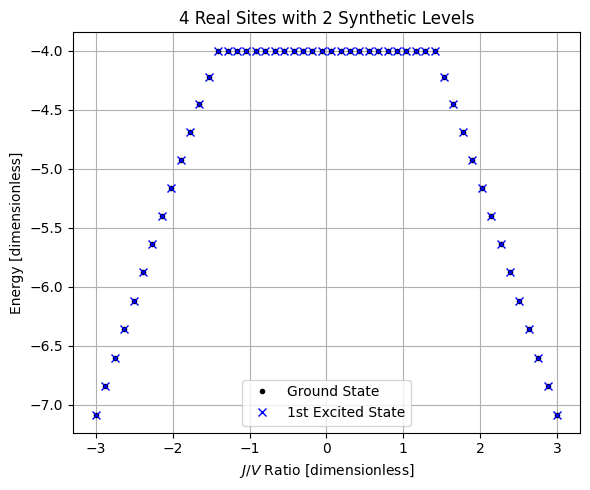

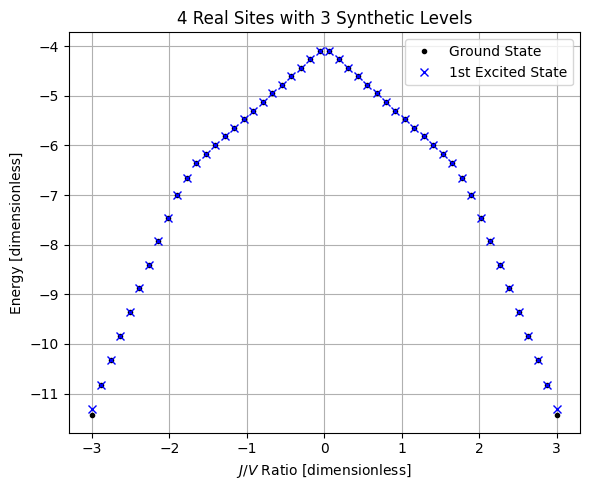

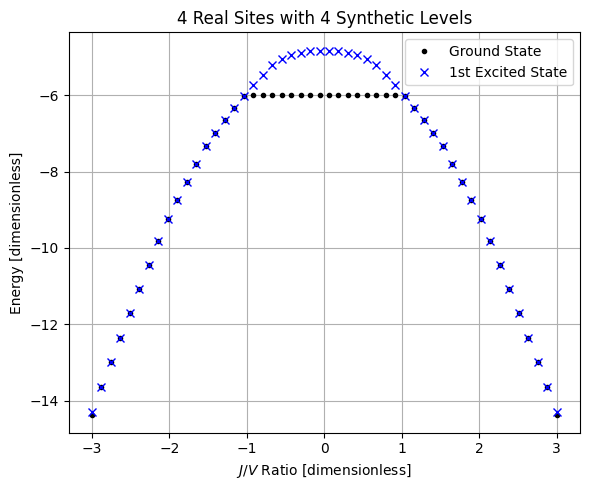

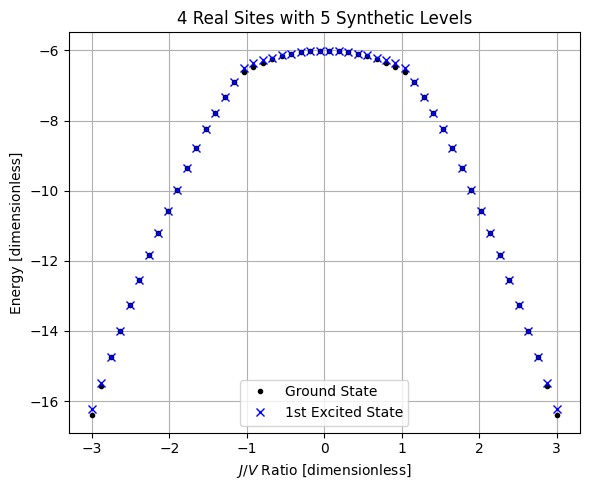

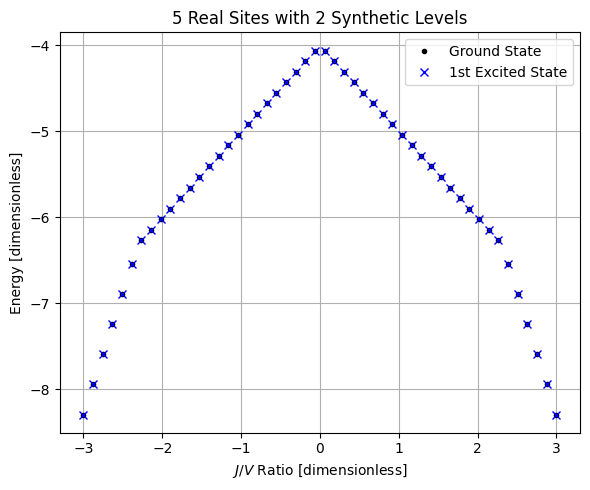

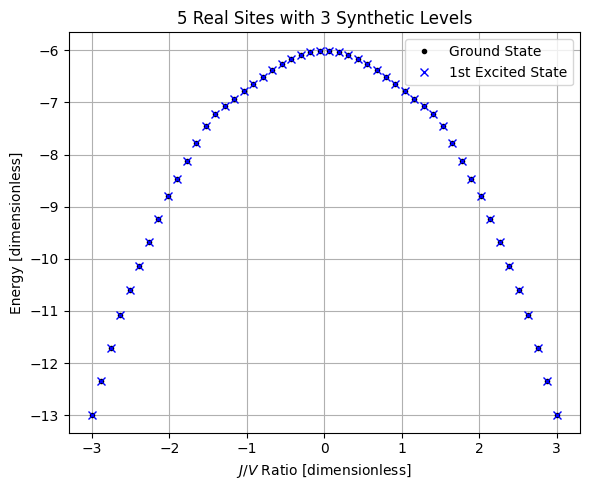

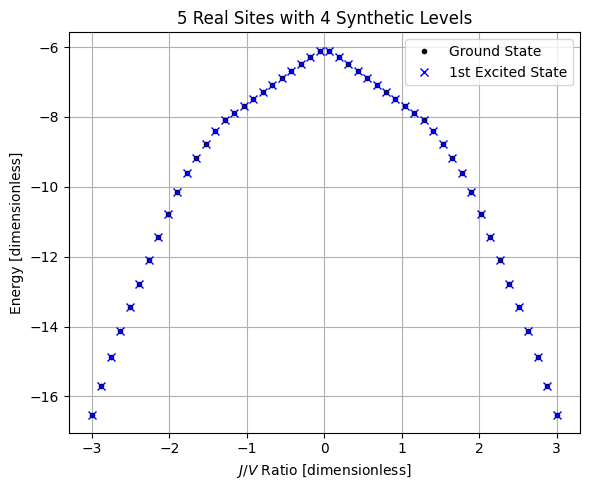

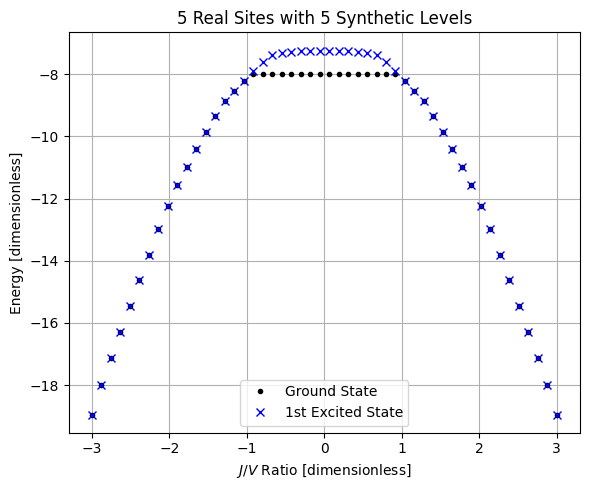

In [16]:
# computing energy spectra for multiple cases

V = 1

for N in [2,3,4,5]:
    for M in [2,3,4,5]:
        
        gs_energies = []
        first_es_energies = []
        second_es_energies = []

        for i, J_V_ratio in enumerate(J_V_ratios):
            J = J_V_ratio * V

            H, formatted_states = construct_hamiltonian(N, M, J, V)
            V_matrix,D_matrix = exact_diagonalize(H)
            eigenvalues = np.diag(D_matrix)
            eigenvectors = [V_matrix[:, col_idx] for col_idx in range(V_matrix.shape[1])]
            
            gs_energies.append(eigenvalues[0])
            first_es_energies.append(eigenvalues[1])
            second_es_energies.append(eigenvalues[2])
            print(f"N={N},M={M}")
            print(f"{i+1}/{len(J_V_ratios)}")
            
        fig, ax = plt.subplots(figsize = (6,5))

        ax.plot(J_V_ratios, gs_energies, ".k", label = "Ground State")
        ax.plot(J_V_ratios, first_es_energies, "xb", label = "1st Excited State")
        #ax.plot(J_V_ratios, second_es_energies, "+r", label = "2nd Excited State")
        ax.set_title(f"{N} Real Sites with {M} Synthetic Levels")
        ax.set_xlabel("$J/V$ Ratio [dimensionless]")
        ax.set_ylabel("Energy [dimensionless]")
        ax.grid()
        ax.legend()
        plt.tight_layout()